In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from enum import Enum
from typing import NamedTuple
from time import sleep

# Third-Party Library Imports
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import xarray as xr
from scipy.stats import spearmanr

# Plotting imports
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import constants
import utils
import plotting_utils
import climate_utils
import stats
import time_of_emrgence_calc as toe
import toe_constants as toe_const
import open_data
from toe_constants import PVALUE_THESHOLD1, OVERLAP_THRESHOLD, SN_THRESHOLD1
import time_of_emergence_plots
import toe_constants as toe_const
import plotting_utils
import misc
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")

Matplotlib created a temporary cache directory at /jobfs/125320798.gadi-pbs/matplotlib-w5dv8ozv because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
xr.set_options(display_expand_data=False)

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.function_base')

In [4]:
# import matplotlib.pylab as pylab
# pylab.rcParams.update({'axes.labelsize':20, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'figure.figsize': [12, 6]})

In [5]:
# client.close()

In [6]:
from dask.distributed import Client
client = Client(threads_per_worker=1, n_workers=12)
client

 - State start
 -   Scheduler at:     tcp://127.0.0.1:44975
 -   dashboard at:         /proxy/8787/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:33037'
 -         Start Nanny at: 'tcp://127.0.0.1:43897'
 -         Start Nanny at: 'tcp://127.0.0.1:44671'
 -         Start Nanny at: 'tcp://127.0.0.1:37085'
 -         Start Nanny at: 'tcp://127.0.0.1:45913'
 -         Start Nanny at: 'tcp://127.0.0.1:39367'
 -         Start Nanny at: 'tcp://127.0.0.1:38817'
 -         Start Nanny at: 'tcp://127.0.0.1:37501'
 -         Start Nanny at: 'tcp://127.0.0.1:36635'
 -         Start Nanny at: 'tcp://127.0.0.1:43217'
 -         Start Nanny at: 'tcp://127.0.0.1:38975'
 -         Start Nanny at: 'tcp://127.0.0.1:34609'
 - Register worker <WorkerState 'tcp://127.0.0.1:35301', name: 3, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:35301
 - Starting established connection to tcp://127.0.0.1:36020
 - Register worker <Wo

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 12
Total threads: 12,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44975,Workers: 12
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:33073,Total threads: 1
Dashboard: /proxy/45089/status,Memory: 768.00 MiB
Nanny: tcp://127.0.0.1:33037,


In [7]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

In [8]:
OPEN_KWARGS = dict(use_cftime=True, drop_variables=['lat_bnds', 'time_bnds', 'lon_bnds'],
                  chunks={'time':-1, 'lat':50})

In [9]:
# hist_ds = xr.open_dataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Amon/pr/gn/latest/pr_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc',
#                          **OPEN_KWARGS)

# ssp585_p1_ds = xr.open_dataset('/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp585/r10i1p1f1/Amon/pr/gn/latest/pr_Amon_ACCESS-ESM1-5_ssp585_r10i1p1f1_gn_201501-210012.nc',
#                           **OPEN_KWARGS)

# ssp585_p2_ds = xr.open_dataset('/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp585/r10i1p1f1/Amon/pr/gn/latest/pr_Amon_ACCESS-ESM1-5_ssp585_r10i1p1f1_gn_210101-230012.nc',
#                               **OPEN_KWARGS)
# data_raw_ds = xr.concat([hist_ds['pr'], ssp585_p1_ds['pr'], ssp585_p2_ds['pr']], dim='time')

# data_ds = data_raw_ds*86400

# data_ds = data_ds.resample(time='QS-DEC').sum().compute()
# data_ds = data_ds.where(data_ds.time.dt.month == 12, drop=True)
# # There are negative values for some reason. For now just remove them and move on.
# data_ds = data_ds.where(data_ds >=0, data_ds, 0)

# # The last year isn't correct. The sum QS-DEC bug this. Just removing both though
# data_ds = data_ds.sel(time=data_ds.time.dt.year< 2299)
# data_ds

In [10]:
# data_ds = xr.open_dataarray('/g/data/w40/ab2313/PhD/time_of_emergence/20CR_ACCESS_SSP585.nc')

In [11]:
data_ds = open_data.open_best()
# data_ds = open_data.open_gpcc()a
# data_ds = data_ds.resample(time='QS-DEC').sum().compute()
# data_ds = data_ds.sel(time=data_ds.time.dt.month==12)

Opening best dataset from - /g/data/w40/ab2313/PhD/time_of_emergence/best/Land_and_Ocean_LatLong1_time_chunk.zarr


FileNotFoundError: No such file or directory: '/g/data/w40/ab2313/PhD/time_of_emergence/best/Land_and_Ocean_LatLong1_time_chunk.zarr'

In [100]:
dataset_name =  'best' #'access_esm15'
variable = data_ds.name
variable

'temperature'

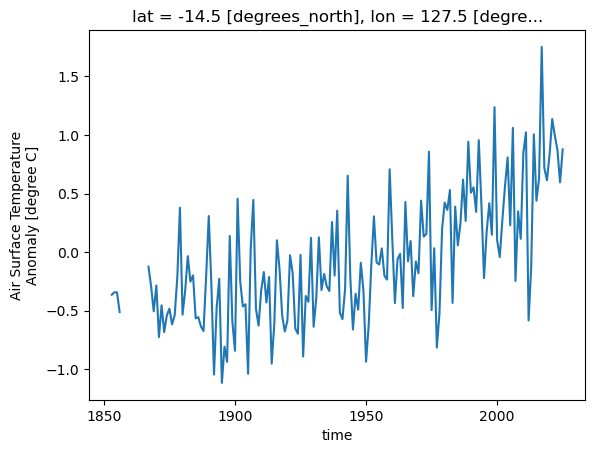

In [14]:
data_ds.sel(lat=-15, lon=127, method='nearest').plot()

In [15]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1900, 1950)#(1900, 1931)
data_ds = data_ds.sel(time=data_ds.time.dt.year>=start_end_tuple[0])
data_ds

<xarray.DataArray 'temperature' (time: 125, lat: 180, lon: 360)> Size: 32MB
array([[[  nan, ...,   nan],
        ...,
        [ 0.22, ...,  0.22]],

       ...,

       [[-2.09, ..., -2.09],
        ...,
        [ 2.25, ...,  2.24]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1900-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (5)

Text(0.5, 1.0, 'Year 2000')

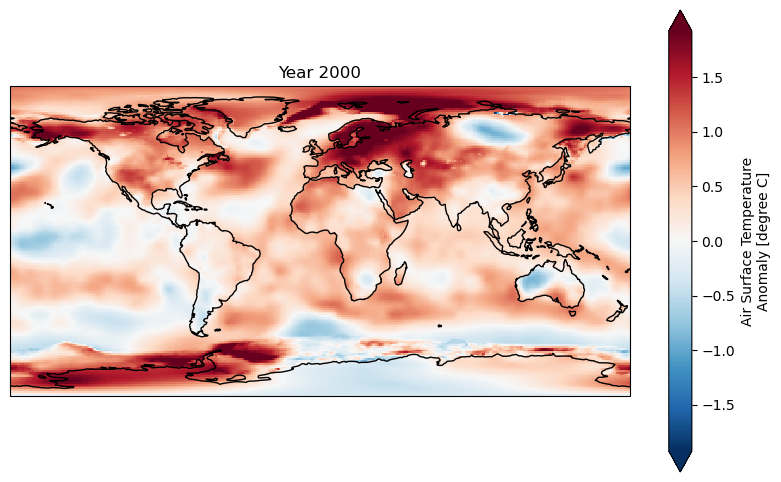

In [16]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_ds.isel(time=100).plot(ax=ax,robust=True)
ax.coastlines()
ax.set_title('Year 2000')

In [17]:
base_period_ds = data_ds.where(data_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)> Size: 13MB
array([[[  nan, ...,   nan],
        ...,
        [ 0.22, ...,  0.22]],

       ...,

       [[  nan, ...,   nan],
        ...,
        [-0.2 , ..., -0.2 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 400B 1900-12-31 00:00:00 ... 1949-12-31 00:00:00
Attributes: (5)

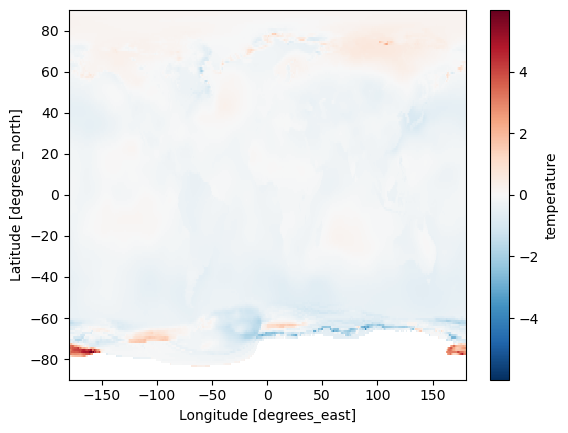

In [18]:
base_period_ds.mean(dim='time').plot()

In [19]:
base_period_ds_count = base_period_ds.count(dim='time')

In [20]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
data_availability_mask = xr.where(base_period_ds_count>=40, 1, 0)
data_availability_mask

<xarray.DataArray 'temperature' (lat: 180, lon: 360)> Size: 518kB
array([[0, ..., 0],
       ...,
       [1, ..., 1]])
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

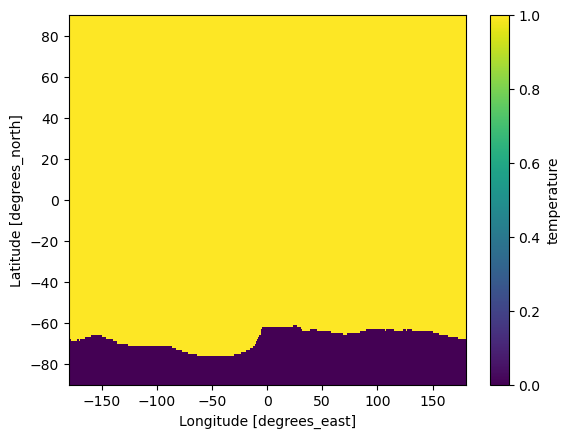

In [21]:
data_availability_mask.plot()

In [22]:
# Apply the mask to both the base period and the full dataset
data_ds = data_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

In [23]:
# Resetting the anomlies to 1850
data_ds = data_ds - base_period_ds.mean(dim='time')
base_period_ds = base_period_ds - base_period_ds.mean(dim='time')

In [24]:
land_mask_ds = xr.open_dataarray('/g/data/w40/ab2313/PhD/time_of_emergence/best/best_mask.zarr')
land_mask_ds

<xarray.DataArray 'land_mask' (lat: 180, lon: 360)> Size: 518kB
[64800 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes: (5)

# Part I: Method Comparison

## Dataset set-up

In [25]:
# P-value methods works better with a large cluster.
# Small chunks with large computation
client.cluster.scale(28)
sleep(7)

 -         Start Nanny at: 'tcp://127.0.0.1:45683'
 -         Start Nanny at: 'tcp://127.0.0.1:43269'
 -         Start Nanny at: 'tcp://127.0.0.1:36061'
 -         Start Nanny at: 'tcp://127.0.0.1:37637'
 -         Start Nanny at: 'tcp://127.0.0.1:40357'
 -         Start Nanny at: 'tcp://127.0.0.1:35391'
 -         Start Nanny at: 'tcp://127.0.0.1:41769'
 -         Start Nanny at: 'tcp://127.0.0.1:34809'
 -         Start Nanny at: 'tcp://127.0.0.1:41349'
 -         Start Nanny at: 'tcp://127.0.0.1:43331'
 -         Start Nanny at: 'tcp://127.0.0.1:40405'
 -         Start Nanny at: 'tcp://127.0.0.1:46083'
 -         Start Nanny at: 'tcp://127.0.0.1:41855'
 -         Start Nanny at: 'tcp://127.0.0.1:33245'
 -         Start Nanny at: 'tcp://127.0.0.1:46227'
 -         Start Nanny at: 'tcp://127.0.0.1:46221'


In [26]:
window = 20

In [27]:
# CHUNKS_FOR_PVALUE_TESTS =  {'lat':30, 'lon':30, 'time':-1}
CHUNKS_FOR_PVALUE_TESTS =  {'lat':60, 'lon':30, 'time':-1}

In [28]:
# Creting new datasets that has windown dimnsion for the rolling calculation
data_ds_window = (data_ds
                  .chunk(CHUNKS_FOR_PVALUE_TESTS)
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .persist()) 

base_period_window_ds = (base_period_ds
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist())

In [29]:
data_ds_window

<xarray.DataArray 'temperature' (time: 125, lat: 180, lon: 360, window_dim: 20)> Size: 648MB
dask.array<sliding_window_view, shape=(125, 180, 360, 20), dtype=float32, chunksize=(124, 60, 30, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1900-12-31 00:00:00 ... 2024-12-31 00:00:00
Dimensions without coordinates: window_dim

In [30]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

## OVerlap Methods

In [31]:
# We want 25 steps betwen the 1st and 99th percentile
bins_sudo = np.linspace(np.nanpercentile(data_ds.values, q=1), np.nanpercentile(data_ds.values, q=99), 25)
bins_sudo

array([-1.49, -1.31, -1.13, -0.95, -0.76, -0.58, -0.4 , -0.22, -0.04,
        0.15,  0.33,  0.51,  0.69,  0.87,  1.06,  1.24,  1.42,  1.6 ,
        1.78,  1.97,  2.15,  2.33,  2.51,  2.69,  2.88])

In [32]:
bin_step = np.unique(np.diff(bins_sudo))[0]
bin_step

0.181991123060385

In [33]:
# The full bins should encompass all data, but should be tailored to 1st and 99th percentile
bins = np.arange(np.nanmin(data_ds.values), np.nanmax(data_ds.values), bin_step)

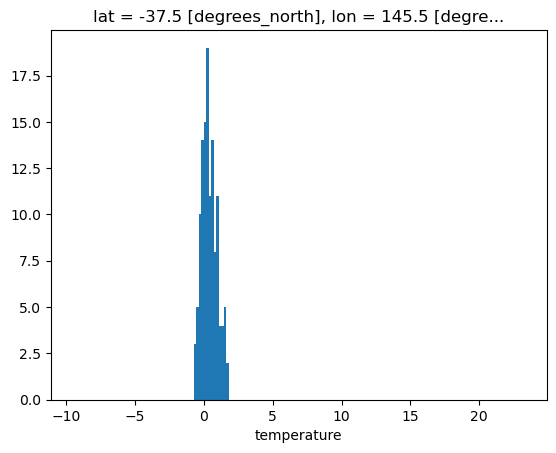

In [34]:
data_ds.sel(lat=-38, lon=145, method='nearest').plot.hist(bins=bins);

In [35]:
%%time
perkins_ds = xr.apply_ufunc(
    toe.perkins_skill_score,
    data_ds_window,
    base_period_window_ds,
    kwargs={'bins': bins},
    output_dtypes=float,
    **rolling_window_kwargs
    ).compute()

CPU times: user 16.1 s, sys: 2.61 s, total: 18.7 s
Wall time: 1min 6s


In [36]:
%%time
frac_geom_ds = xr.apply_ufunc(
    toe.farctional_geometric_area,
    data_ds_window,
    base_period_window_ds,
    output_dtypes=float,
    **rolling_window_kwargs
    ).compute()

CPU times: user 4min 34s, sys: 42.4 s, total: 5min 16s
Wall time: 19min


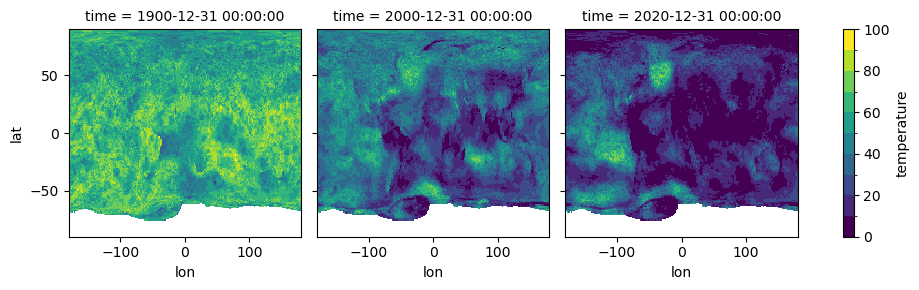

In [37]:
perkins_ds.isel(time=[0, 100, 120]).plot(col='time', levels=np.arange(0, 110, 10))

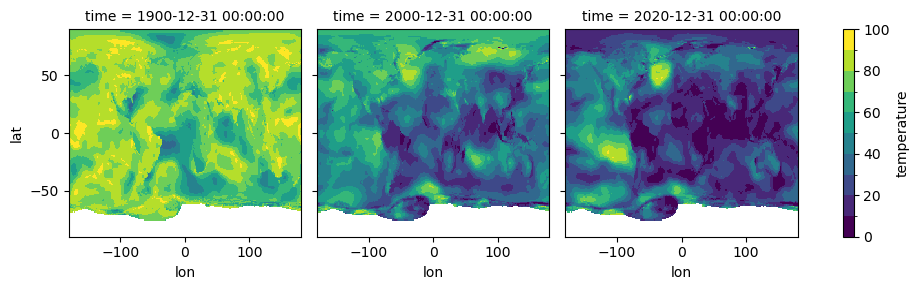

In [38]:
frac_geom_ds.isel(time=[0, 100, 120]).plot(col='time', levels=np.arange(0, 110, 10))

## P-value Methods

1d Array Method <br>

This method comapes starting from the begging and looops through. The nans are added to the end so the length matches

In [39]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [40]:
%%time
# Expected: 9 minutes 30 seconds
ttest_ds = xr.apply_ufunc(
        toe.return_ttest_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 2min 21s, sys: 21.8 s, total: 2min 43s
Wall time: 10min 20s


In [41]:
%%time
# Expected 3 minutes 30 seconds
ks_ds = xr.apply_ufunc(
        toe.return_ks_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 1min 12s, sys: 9.25 s, total: 1min 21s
Wall time: 4min 3s


In [42]:
# ks_2samp will perfom on all nan slices
# ks_ds = ks_ds.where(data_ava`ilability_mask)

In [43]:
%%time
anderson_ds = xr.apply_ufunc(
    toe.return_anderson_pvalue,
    data_ds_window,
    base_period_window_ds,
    output_dtypes=float, 
    **rolling_window_kwargs
    ).compute()

/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emrgence_calc.py:40: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  pval = anderson_ksamp([test_arr, base_arr]).significance_level
/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emrgence_calc.py:40: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  pval = anderson_ksamp([test_arr, base_arr]).significance_level
/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emrgence_calc.py:40: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  pval = anderson_ksamp([test_arr, base_arr]).significance_level
/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emrgence_calc.py:40: UserWarning: p-value floored: true value smaller than 0.001. Consider 

CPU times: user 39 s, sys: 4.81 s, total: 43.8 s
Wall time: 2min 2s


### Verification that method works
Verifyting the abstracted (but faster) methods works by comparing to a single lat, lon point.

In [44]:
# This amount of workers is no longer need
client.cluster.scale(5)
sleep(7)

 - Closing Nanny at 'tcp://127.0.0.1:42805'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:38609'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:32989'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:35401'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:44965'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:42389'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:40261'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:45683'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:43269'. Reason: nan

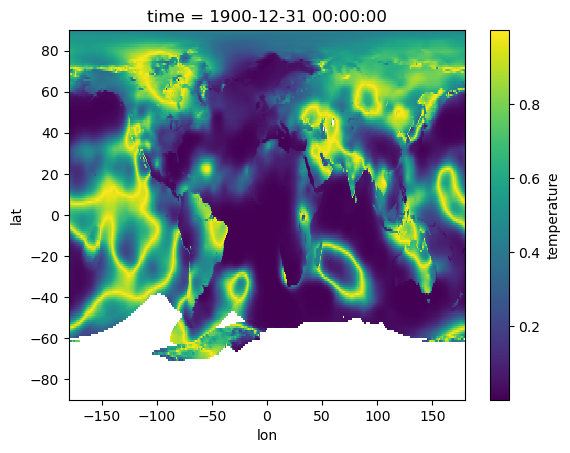

In [45]:
ttest_ds.isel(time=0).plot()

In [46]:
lat_lon_sp = dict(lat=-34, lon=145, method='nearest')

In [47]:
stats_test_1d_array_ttest = partial(
    toe.stats_test_1d_array, stats_func=toe.return_ttest_pvalue, window=window)

stats_test_1d_array_ks = partial(
    toe.stats_test_1d_array, stats_func=toe.return_ks_pvalue, window=window)

In [48]:
ttest_1d_1p = stats_test_1d_array_ttest(data_ds.sel(**lat_lon_sp))

In [49]:
ks_1d_1p = stats_test_1d_array_ks(data_ds.sel(**lat_lon_sp))

In [50]:
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)> Size: 13MB
array([[[  nan, ...,   nan],
        ...,
        [ 0.1 , ...,  0.1 ]],

       ...,

       [[  nan, ...,   nan],
        ...,
        [-0.32, ..., -0.32]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 400B 1900-12-31 00:00:00 ... 1949-12-31 00:00:00

In [51]:
data_ds

<xarray.DataArray 'temperature' (time: 125, lat: 180, lon: 360)> Size: 32MB
array([[[ nan, ...,  nan],
        ...,
        [0.1 , ..., 0.1 ]],

       ...,

       [[ nan, ...,  nan],
        ...,
        [2.13, ..., 2.12]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1900-12-31 00:00:00 ... 2024-12-31 00:00:00

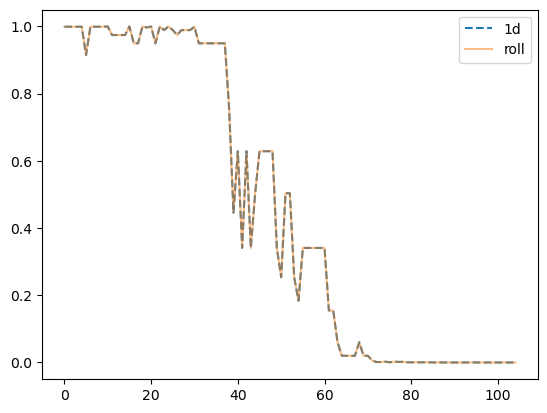

In [52]:
plt.plot(ks_1d_1p,label='1d', linestyle='--')
plt.plot(ks_ds.sel(**lat_lon_sp).isel(time=slice(int(window/2), -int(window/2))).values, label='roll', alpha=0.5)
plt.legend()

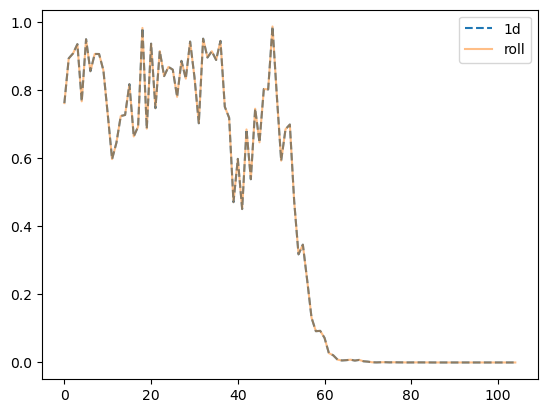

In [53]:
plt.plot(ttest_1d_1p,label='1d', linestyle='--')
plt.plot(ttest_ds.sel(**lat_lon_sp).isel(time=slice(int(window/2), -int(window/2))).values, label='roll', alpha=0.5)
plt.legend()

In [54]:
stats_test_1d_array_anderson = partial(
    toe.stats_test_1d_array, stats_func=toe.return_anderson_pvalue, window=window)

In [55]:
anderson_1d_1p = stats_test_1d_array_anderson(data_ds.sel(**lat_lon_sp))

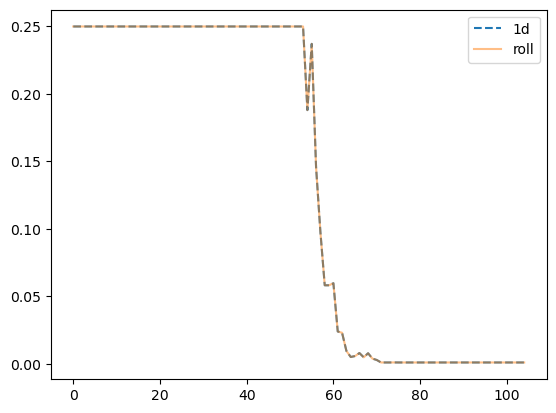

In [56]:
plt.plot(anderson_1d_1p, label='1d', linestyle='--')
plt.plot(anderson_ds.sel(**lat_lon_sp).isel(time=slice(int(window/2), -int(window/2))).values, label='roll', alpha=0.5)
plt.legend()

## Signal-to-Noise (hawkins)

In [57]:
# Calculate the wegithed mean
data_ds_smean = climate_utils.weighted_lat_lon_mean(data_ds)
data_ds_smean

<xarray.DataArray 'temperature' (time: 125)> Size: 500B
array([ 0.08,  0.  , -0.15, -0.26, -0.31, -0.13, -0.04, -0.2 , -0.24,
       -0.31, -0.27, -0.28, -0.2 , -0.18,  0.01,  0.07, -0.17, -0.31,
       -0.15, -0.1 , -0.03,  0.02, -0.06, -0.03, -0.04,  0.  ,  0.14,
        0.02,  0.04, -0.14,  0.08,  0.14,  0.09, -0.09,  0.05, -0.01,
        0.06,  0.22,  0.22,  0.21,  0.29,  0.24,  0.25,  0.31,  0.41,
        0.27,  0.12,  0.19,  0.09,  0.1 ,  0.02,  0.2 ,  0.28,  0.35,
        0.16,  0.07,  0.  ,  0.22,  0.26,  0.23,  0.2 ,  0.24,  0.22,
        0.24, -0.03,  0.09,  0.14,  0.16,  0.11,  0.25,  0.18,  0.06,
        0.17,  0.32,  0.09,  0.17,  0.1 ,  0.42,  0.29,  0.38,  0.45,
        0.53,  0.34,  0.51,  0.32,  0.34,  0.38,  0.52,  0.55,  0.46,
        0.64,  0.6 ,  0.41,  0.5 ,  0.54,  0.69,  0.55,  0.73,  0.88,
        0.64,  0.63,  0.77,  0.83,  0.84,  0.76,  0.9 ,  0.87,  0.85,
        0.75,  0.86,  0.97,  0.82,  0.88,  0.88,  0.96,  1.14,  1.25,
        1.15,  1.05,  1.19,  1.22,  1.09,  1.11,  1.42,  1.55],
      dtype=float32)
Coordinates:
  * time     (time) object 1kB 1900-12-31 00:00:00 ... 2024-12-31 00:00:00

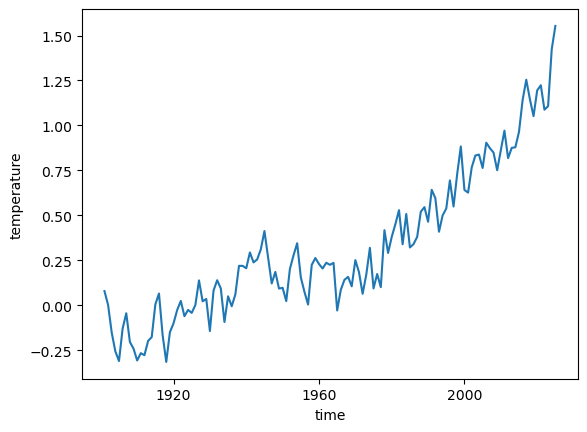

In [58]:
data_ds_smean.plot()

In [59]:
# Get lowess filtered version
data_ds_smean_lowess = stats.trend_fit(data_ds_smean, method='LOWESS', lowess_window=41)

In [60]:
%%time
return_hawkins_signal_and_noise_partial = partial(toe.return_hawkins_signal_and_noise, gt=data_ds_smean_lowess.values)

ds_data_signal, ds_data_noise_series = xr.apply_ufunc(
    return_hawkins_signal_and_noise_partial,
    data_ds,
    input_core_dims=[['time']], 
    output_core_dims=[['time'], ['time']], 
    dask='parallelized', 
    vectorize=True,
    output_dtypes=[float, float],
)

CPU times: user 8.21 s, sys: 1.95 s, total: 10.2 s
Wall time: 7.83 s


In [61]:
# Noise 
ds_data_noise = ds_data_noise_series.std(dim='time').compute()
# Compute signal
ds_data_signal = ds_data_signal.compute()
# S/N Ratio 
ds_data_sn = ds_data_signal/ds_data_noise

In [62]:
client.cluster.scale(18)
sleep(7)

 -         Start Nanny at: 'tcp://127.0.0.1:37757'
 -         Start Nanny at: 'tcp://127.0.0.1:33763'
 -         Start Nanny at: 'tcp://127.0.0.1:33107'
 -         Start Nanny at: 'tcp://127.0.0.1:40691'
 -         Start Nanny at: 'tcp://127.0.0.1:42397'
 -         Start Nanny at: 'tcp://127.0.0.1:33853'
 -         Start Nanny at: 'tcp://127.0.0.1:43469'
 -         Start Nanny at: 'tcp://127.0.0.1:37989'
 -         Start Nanny at: 'tcp://127.0.0.1:39209'
 -         Start Nanny at: 'tcp://127.0.0.1:44153'
 -         Start Nanny at: 'tcp://127.0.0.1:41259'
 -         Start Nanny at: 'tcp://127.0.0.1:32947'
 -         Start Nanny at: 'tcp://127.0.0.1:33805'


In [63]:
ds_data_signal_lowess = xr.apply_ufunc(
    stats.apply_lowess, 
    data_ds.chunk({'time':-1, 'lat':10}), 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True, 
    dask='parallelized',    
).compute()


In [64]:
# Noise series is detrended data
ds_data_noise_series_lowess = data_ds - ds_data_signal_lowess
# Noise is std of detrended data
ds_data_noise_lowess = ds_data_noise_series_lowess.std(dim='time').compute()
# S/N Ratio
ds_data_sn_lowess = ds_data_signal_lowess/ds_data_noise_lowess

In [65]:
# Rolling noise variant
ds_data_noise_lowess_rolling = ds_data_noise_series_lowess.rolling(time=window, min_periods=2).std(dim='time').compute()
# First time step is nan, so remove
# ds_data_noise_lowess_rolling = ds_data_noise_lowess_rolling.isel(time=slice(1, None))
# This is odd. But I am making the fire 19 years (wnindow lenght) have the same noise as the first time the 
# variability can be calculated.
# ds_data_noise_lowess_rolling = xr.concat([
#     ds_data_noise_lowess_rolling.isel(time=slice(0, window-2)).fillna(ds_data_noise_lowess_rolling.isel(time=window-1)),
#     ds_data_noise_lowess_rolling.isel(time=slice(window-1, None))], dim='time')
# ds_data_noise_lowess_rolling = misc.adjust_time_from_rolling(ds_data_noise_lowess_rolling, window)

In [66]:
ds_data_noise_lowess_rolling.sel(lat=-40, lon=144, method='nearest')

<xarray.DataArray 'temperature' (time: 125)> Size: 1kB
array([ nan, 0.14, 0.12, 0.12, 0.11, 0.22, 0.22, 0.24, 0.23, 0.23, 0.24,
       0.24, 0.24, 0.24, 0.27, 0.26, 0.26, 0.25, 0.31, 0.32, 0.32, 0.35,
       0.37, 0.36, 0.37, 0.35, 0.35, 0.32, 0.32, 0.32, 0.32, 0.35, 0.35,
       0.36, 0.36, 0.36, 0.36, 0.36, 0.34, 0.33, 0.33, 0.3 , 0.27, 0.27,
       0.28, 0.28, 0.29, 0.29, 0.3 , 0.31, 0.31, 0.31, 0.32, 0.31, 0.29,
       0.29, 0.3 , 0.3 , 0.28, 0.28, 0.27, 0.32, 0.32, 0.32, 0.31, 0.32,
       0.31, 0.32, 0.3 , 0.26, 0.26, 0.25, 0.25, 0.25, 0.26, 0.26, 0.26,
       0.25, 0.24, 0.24, 0.24, 0.2 , 0.2 , 0.2 , 0.19, 0.16, 0.17, 0.2 ,
       0.22, 0.23, 0.24, 0.24, 0.25, 0.25, 0.25, 0.29, 0.33, 0.33, 0.34,
       0.34, 0.37, 0.38, 0.38, 0.38, 0.39, 0.39, 0.4 , 0.39, 0.37, 0.36,
       0.34, 0.34, 0.34, 0.35, 0.35, 0.32, 0.27, 0.26, 0.26, 0.26, 0.26,
       0.23, 0.22, 0.23, 0.22])
Coordinates:
    lat      float32 4B -39.5
    lon      float32 4B 144.5
  * time     (time) object 1kB 1900-12-31 00:00:00 ... 2024-12-31 00:00:00

In [67]:
ds_data_sn_lowess_rolling = ds_data_signal_lowess/ds_data_noise_lowess_rolling
# First time step is nan for noise, so remove
ds_data_sn_lowess_rolling = ds_data_sn_lowess_rolling.isel(time=slice(1, None))

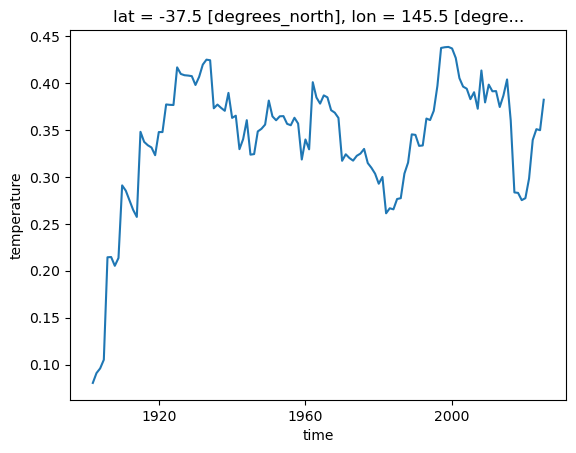

In [68]:
ds_data_noise_lowess_rolling.sel(lat=-38, lon=145, method='nearest').plot()

In [69]:
ds_data_sn_lowess

<xarray.DataArray 'temperature' (lat: 180, lon: 360, time: 125)> Size: 65MB
array([[[  nan, ...,   nan],
        ...,
        [  nan, ...,   nan]],

       ...,

       [[-0.54, ...,  3.01],
        ...,
        [-0.54, ...,  3.01]]])
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1900-12-31 00:00:00 ... 2024-12-31 00:00:00

In [70]:
client.cluster.scale(6)
sleep(7)

 - Closing Nanny at 'tcp://127.0.0.1:37757'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:33763'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:33107'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:40691'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:42397'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:33853'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:43469'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:37989'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:44153'. Reason: nan

### Verification Plots

In [71]:
sel_dict = dict(lat=-38, lon=144, method='nearest')

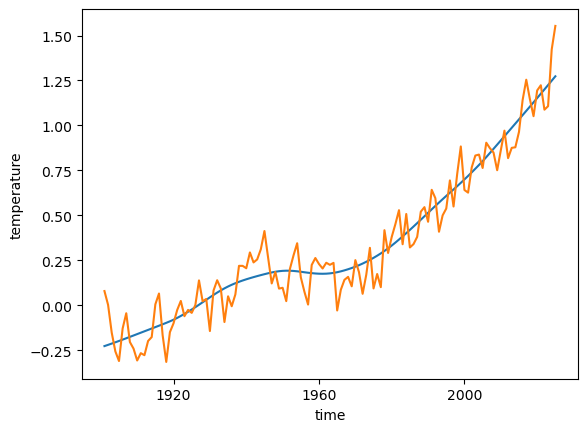

In [72]:
data_ds_smean_lowess.plot()
data_ds_smean.plot()

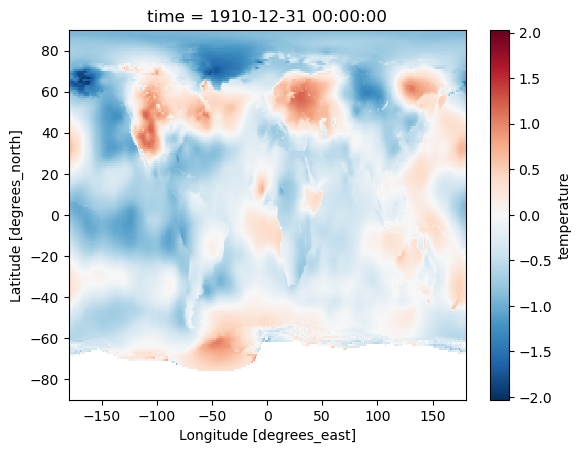

In [73]:
data_ds.isel(time=10).plot()

In [74]:
# Veriftying for a single point
signal_sp, noise_series_sp, reocnstructed_sp =\
    return_hawkins_signal_and_noise_partial(
        data_ds.sel(**sel_dict).values, return_reconstruction=True)

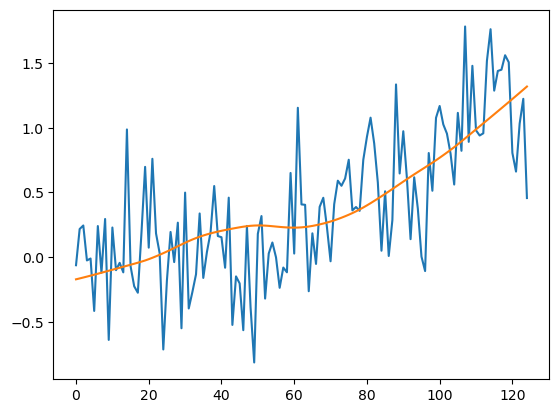

In [75]:
# Thhe reconstruced should thread the original data.
# The reconstructed int the scaled version of the global
plt.plot(data_ds.sel(**sel_dict).values)
plt.plot(reocnstructed_sp)

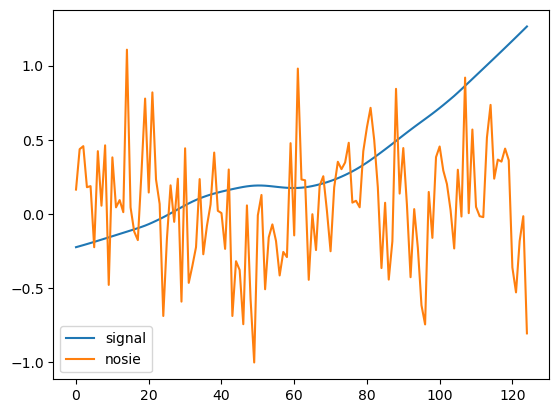

In [76]:
plt.plot(signal_sp, label='signal')
plt.plot(noise_series_sp, label='nosie')
plt.legend()

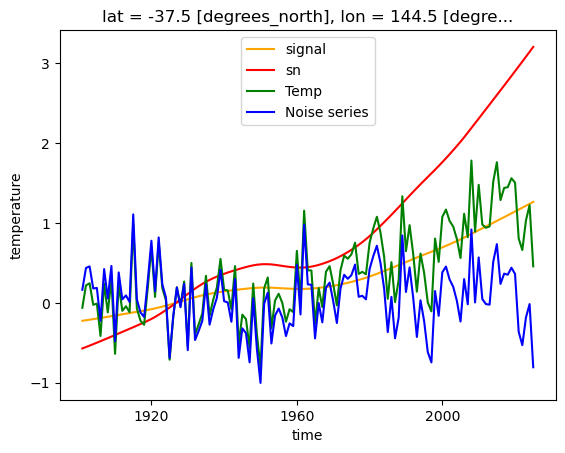

In [77]:
fig, ax1 = plt.subplots(1, 1)
ax2 = ax1#.twinx()
ds_data_signal.sel(**sel_dict).plot(ax=ax1, label='signal', color='orange')
ds_data_sn.sel(**sel_dict).plot(ax=ax1, label='sn', color='red')

data_ds.sel(**sel_dict).plot(ax=ax2, label='Temp', color='green')
ds_data_noise_series.sel(**sel_dict).plot(ax=ax2, color='blue', label='Noise series')

ax1.legend()
ax2.legend(loc='upper center')

Text(0.5, 1.0, 'LOWESS VERSION')

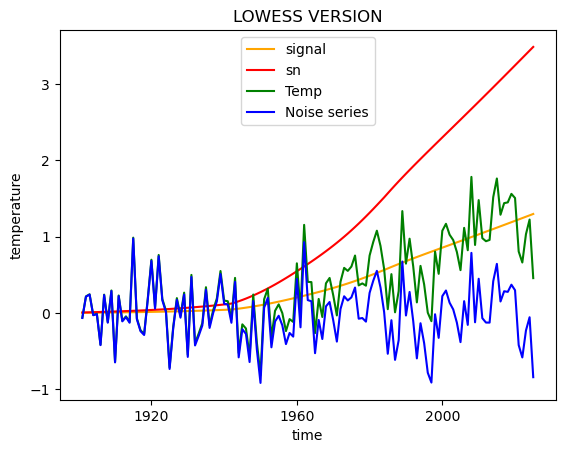

In [78]:
fig, ax1 = plt.subplots(1, 1)
ax2 = ax1#.twinx()
ds_data_signal_lowess.sel(**sel_dict).plot(ax=ax1, label='signal', color='orange')
ds_data_sn_lowess.sel(**sel_dict).plot(ax=ax1, label='sn', color='red')

data_ds.sel(**sel_dict).plot(ax=ax2, label='Temp', color='green')
ds_data_noise_series_lowess.sel(**sel_dict).plot(ax=ax2, color='blue', label='Noise series')

ax1.legend()
ax2.legend(loc='upper center')

ax1.set_title('LOWESS VERSION')

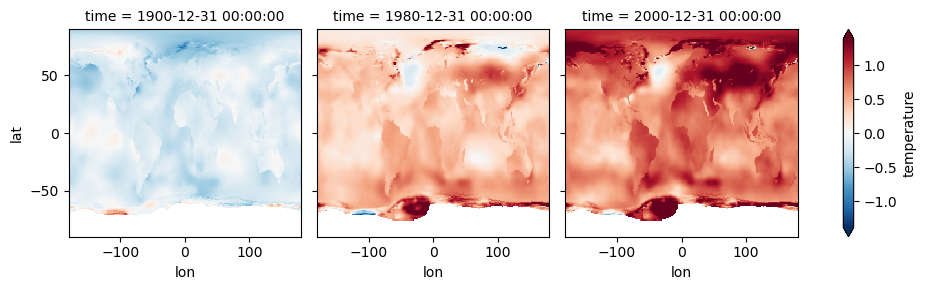

In [79]:
ds_data_signal_lowess.isel(time=[0, 80, 100]).plot(col='time', robust=True)

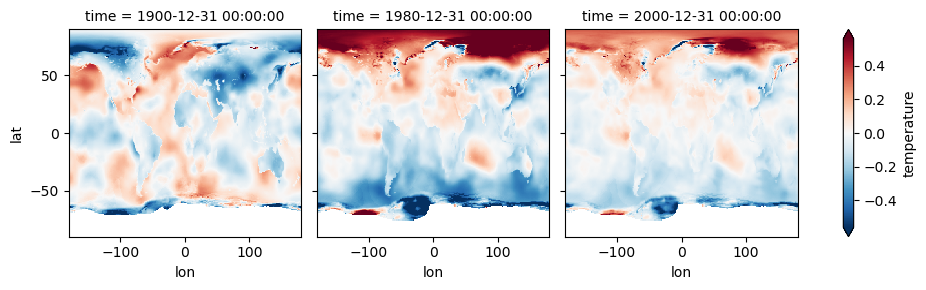

In [80]:
(ds_data_signal.isel(time=[0, 80, 100])-ds_data_signal_lowess.isel(time=[0, 80, 100])).plot(col='time', robust=True)

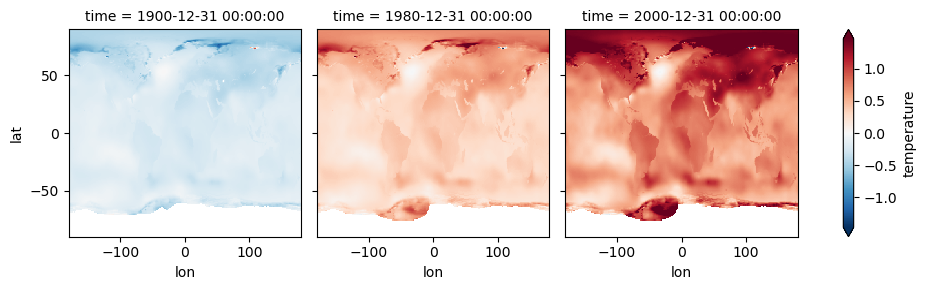

In [81]:
ds_data_signal.isel(time=[0, 80, 100]).plot(col='time', robust=True)

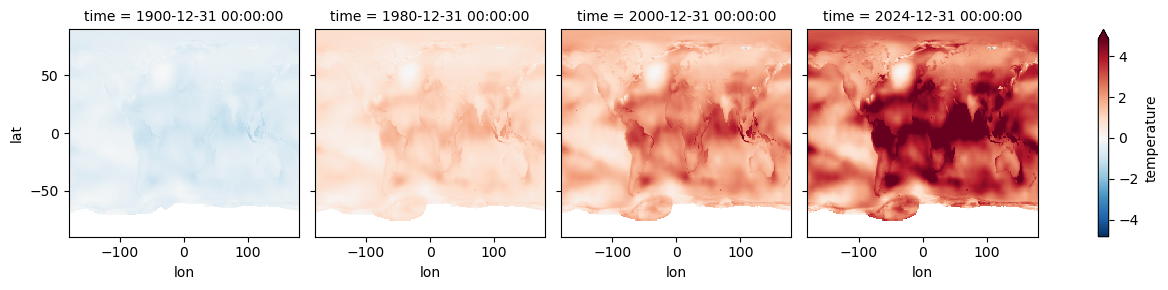

In [82]:
ds_data_sn.isel(time=[0, 80, 100, -1]).plot(col='time', robust=True)

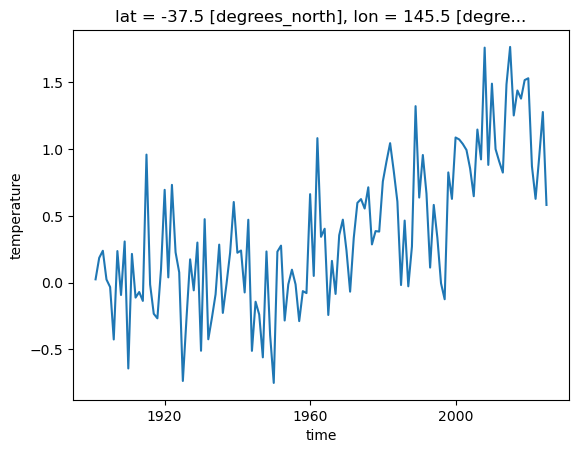

In [83]:
data_ds.sel(lat=-38, lon=145, method='nearest').plot(label='rainfall')


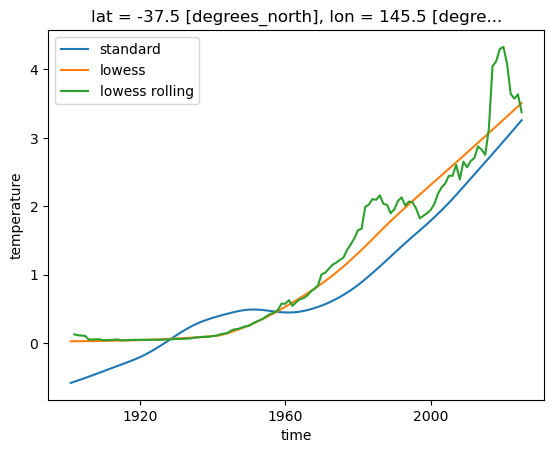

In [84]:
ds_data_sn.sel(lat=-38, lon=145, method='nearest').plot(label='standard')
ds_data_sn_lowess.sel(lat=-38, lon=145, method='nearest').plot(label='lowess')
ds_data_sn_lowess_rolling.sel(lat=-38, lon=145, method='nearest').plot(label='lowess rolling')
plt.legend()

## Emergence Calculation

In [85]:
ds_data_signal.name = 'signal'
ds_data_signal_lowess.name = 'signal_lowess'
ds_data_noise_series_lowess.name = 'noise_lowess'
ds_data_noise_lowess_rolling.name = 'noise_lowess_rolling'
# ds_data_sn_lowess_rolling.name = 'signal_lowess_rolling'

In [86]:
ds_data_sn.name = 'sn'
ds_data_sn_lowess.name = 'sn_lowess'
ds_data_sn_lowess_rolling.name = 'sn_lowess_rolling'


ttest_ds.name = 'ttest'
ks_ds.name = 'ks'
anderson_ds.name = 'anderson'
perkins_ds.name = 'perkins'
frac_geom_ds.name = 'frac'

In [87]:
# Set long name attributes for each variable
ds_data_sn.attrs['long_name'] = 'S/N Ratio'
ds_data_sn_lowess.attrs['long_name'] = 'S/N Ratio (LOWESS)'
ds_data_sn_lowess_rolling.attrs['long_name'] = 'S/N Ratio (LOWESS, Rolling)'


ks_ds.attrs['long_name'] = 'Kolmogorov-Smirnov'
ttest_ds.attrs['long_name'] = 'T-Test'
anderson_ds.attrs['long_name'] = 'Anderson-Darling'
perkins_ds.attrs['long_name'] = 'Perkins Skill Score'
frac_geom_ds.attrs['long_name'] = 'Fractional Geometric Area'

In [88]:
toe_metrics_ds = xr.merge([ks_ds, ttest_ds, anderson_ds, ds_data_sn, perkins_ds, frac_geom_ds, 
                          ds_data_sn_lowess, ds_data_sn_lowess_rolling])
toe_metrics_ds = toe_metrics_ds.isel(time=slice(int(window/2), -int(window/2)))
toe_metrics_ds = toe_metrics_ds.compute()
toe_metrics_ds

<xarray.Dataset> Size: 435MB
Dimensions:            (lat: 180, lon: 360, time: 105)
Coordinates:
  * lat                (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                (lon) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * time               (time) object 840B 1910-12-31 00:00:00 ... 2014-12-31 ...
Data variables:
    ks                 (time, lat, lon) float64 54MB nan nan ... 1.82e-11
    ttest              (time, lat, lon) float64 54MB nan nan ... 3.238e-15
    anderson           (time, lat, lon) float64 54MB nan nan nan ... 0.001 0.001
    sn                 (lat, lon, time) float64 54MB nan nan nan ... 2.287 2.34
    perkins            (time, lat, lon) float64 54MB nan nan nan ... 8.0 8.0 8.0
    frac               (time, lat, lon) float64 54MB nan nan nan ... 21.12 21.11
    sn_lowess          (lat, lon, time) float64 54MB nan nan nan ... 2.207 2.278
    sn_lowess_rolling  (lat, lon, time) float64 54MB nan nan nan ... 1.844 1.944
Attributes: (1)

In [89]:
constants.TOE_SAVE_DIR

'/g/data/w40/ab2313/PhD/time_of_emergence/toe_metrics'

In [101]:
# There is also a lot of processing that has been udnergone for this dataset.
# Worth saving just to keep complete consistency
DATA_SAVE_NAME = os.path.join(constants.TOE_SAVE_DIR, f'{variable}/{dataset_name}_data.nc')
print(DATA_SAVE_NAME)
data_ds.to_netcdf(DATA_SAVE_NAME)

/g/data/w40/ab2313/PhD/time_of_emergence/toe_metrics/temperature/best_data.nc


In [102]:
# THe signal is actually needed for lots of plots
singal_ds = xr.merge([ds_data_signal, ds_data_signal_lowess, ds_data_noise_series_lowess, ds_data_noise_lowess_rolling]) 
singal_ds

<xarray.Dataset> Size: 259MB
Dimensions:               (lat: 180, lon: 360, time: 125)
Coordinates:
  * lat                   (lat) float32 720B -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                   (lon) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * time                  (time) object 1kB 1900-12-31 00:00:00 ... 2024-12-3...
Data variables:
    signal                (lat, lon, time) float64 65MB nan nan ... 2.431 2.478
    signal_lowess         (lat, lon, time) float64 65MB nan nan ... 2.339 2.399
    noise_lowess          (time, lat, lon) float64 65MB nan nan ... -0.2739
    noise_lowess_rolling  (time, lat, lon) float64 65MB nan nan ... 0.8109

In [103]:
SIGNAL_SAVE_NAME = os.path.join(constants.TOE_SAVE_DIR, f'{variable}/{dataset_name}_signal.nc')
print(SIGNAL_SAVE_NAME)
singal_ds.to_netcdf(SIGNAL_SAVE_NAME)

/g/data/w40/ab2313/PhD/time_of_emergence/toe_metrics/temperature/best_signal.nc


In [104]:
TOE_METRICS_SAVE_NAME = os.path.join(constants.TOE_SAVE_DIR, f'{variable}/{dataset_name}_toe_metrics.nc')
print(TOE_METRICS_SAVE_NAME)
toe_metrics_ds.to_netcdf(TOE_METRICS_SAVE_NAME)

/g/data/w40/ab2313/PhD/time_of_emergence/toe_metrics/temperature/best_toe_metrics.nc
